In [1]:
"""Note: this nb is self-contained, just requires the one saved pkl model in the results folder.
The point is to show evidence that BERT-like models meaningfully capture embeddings via summation.
One nice plot would be showing that emb('not') + emb('good') is close to emb('not good')
Another nice plot would be showing that, when trained on embeddings, coef('not') + coef('good') is not equal to coef('not good')
"""

%load_ext autoreload
%autoreload 2
import torch
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import datasets
import numpy as np
import os.path
from spacy.lang.en import English
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
from auggam import analyze_helper
import dvu
dvu.set_style()
import pandas as pd
from os.path import join as oj
import string
from typing import List
import data
import matplotlib.pyplot as plt
import seaborn as sns
from auggam import config
pd.set_option('display.max_rows', None)

In [11]:
d.to_pickle(oj(config.misc_dir, 'top_interacting_words_df2.pkl'))

# Let's compare bert coefs to the BOW coefs

In [12]:
df = pd.read_csv(oj(config.misc_dir, 'df_unigram_sst.csv'), index_col=0)
df2 = pd.read_csv(oj(config.misc_dir, 'df_bigram_sst.csv'), index_col=0)
d = pkl.load(open(oj(config.misc_dir, 'top_interacting_words_df2.pkl'), 'rb'))
# d = pd.read_csv('/home/chansingh/aug-models/auggam/top_interacting_words_df2.csv')

embs = pkl.load(open(oj(config.misc_dir, 'word_embs_sst_train.pkl'), 'rb'))
embs2 = pkl.load(open(oj(config.misc_dir, 'embs2_sst_top_interactions.pkl'), 'rb'))

# Plot the correlations of the embeddings of the unigrams with the highest absolute value coefficients.
# analyze_helper.corrplot_max_abs_unigrams(df, embs)

not bad
not


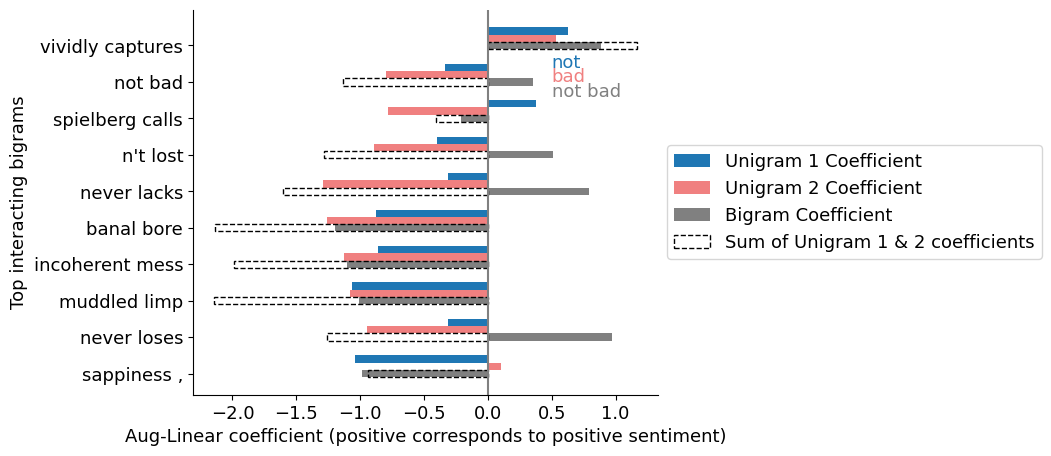

In [15]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(6, 5))
ax = plt.subplot(111)

idxs = np.arange(10)
dp = d.iloc[idxs]

idxs = idxs[::-1]
# plt.barh(idxs, dp['coef'], height=0.3)
# plt.barh(idxs + 0.3, dp['coef1'], height=0.3)
# plt.barh(idxs + 0.6, dp['coef2'], height=0.3)
height = 0.2

cmid = '#996680'
plt.barh(idxs + 2 * height, dp['bert_coef_unigram1'], height=height, label='Unigram 1 Coefficient', color='C0') #, color=dvu.cb)
plt.barh(idxs + height, dp['bert_coef_unigram2'], height=height, label='Unigram 2 Coefficient', color='lightcoral') #, color=dvu.cr)
plt.barh(idxs, dp['bert_coef_bigram'], height=height, label='Bigram Coefficient', color='gray') #, color=cmid)
plt.barh(idxs, dp['bert_coef_unigram1'] + dp['bert_coef_unigram2'], linestyle='--',
            height=height, label='Sum of Unigram 1 & 2 coefficients', fill=False) #, color=dvu.cr)

prop_cycle = plt.rcParams['axes.prop_cycle']
cs = prop_cycle.by_key()['color']
ex_idx = 1
ex_one = dp.iloc[ex_idx]
offset = ex_idx + 0.2
print(ex_one.bigram)
print(ex_one.unigram1)
plt.text(x=0.5, y=idxs.max() + height * 2 + height - offset, s=ex_one.unigram1, color='C0')
plt.text(x=0.5, y=idxs.max() + height - offset, s=ex_one.unigram2, color='lightcoral')
plt.text(x=0.5, y=idxs.max() - height - offset, s=ex_one.bigram, color='gray')
plt.ylabel('Top interacting bigrams')

# plt.text(x=ex_one.unigram1, y=idxs.max() + height * 2 + height - offset, s=ex_one.unigram1, color=cs[0])
# plt.text(x=0.5, y=idxs.max() + height - offset, s=ex_one.unigram2, color=cs[1])
# plt.text(x=0.5, y=idxs.max() - height - offset, s=ex_one.bigram, color='gray')

plt.axvline(0, color='gray')
plt.yticks(idxs, dp['bigram'])
plt.xlabel('Aug-Linear coefficient (positive corresponds to positive sentiment)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.tight_layout()
plt.savefig('../results/bert_coefs_learn_interactions.pdf', bbox_inches="tight")
plt.show()

# less clear plots

**bert coefs are similar to bigram coefs**

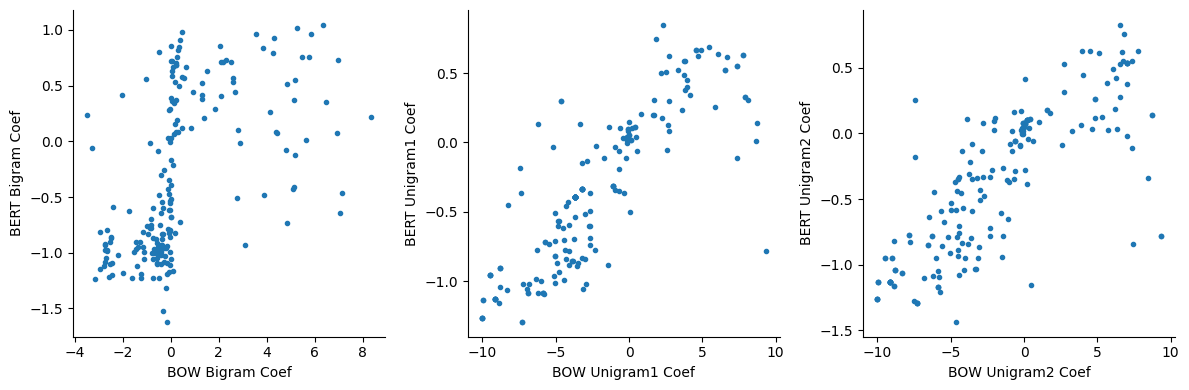

In [50]:
R, C = 1, 3
# fig, axes = plt.subplots(R, C)
# .lmplot(x='coef', y='bert_coef_bigram', data=d, ax=axes[0])
plt.figure(figsize=(12, 4))
plt.subplot(R, C, 1)
plt.plot(d['coef'], d['bert_coef_bigram'], '.')
plt.xlabel('BOW Bigram Coef')
plt.ylabel('BERT Bigram Coef')

plt.subplot(R, C, 2)
plt.plot(d['coef1'], d['bert_coef_unigram1'], '.')
plt.xlabel('BOW Unigram1 Coef')
plt.ylabel('BERT Unigram1 Coef')

plt.subplot(R, C, 3)
plt.plot(d['coef2'], d['bert_coef_unigram2'], '.')
plt.xlabel('BOW Unigram2 Coef')
plt.ylabel('BERT Unigram2 Coef')
plt.tight_layout()
plt.savefig('results/bert_bow_coef_compare.pdf')
plt.show()

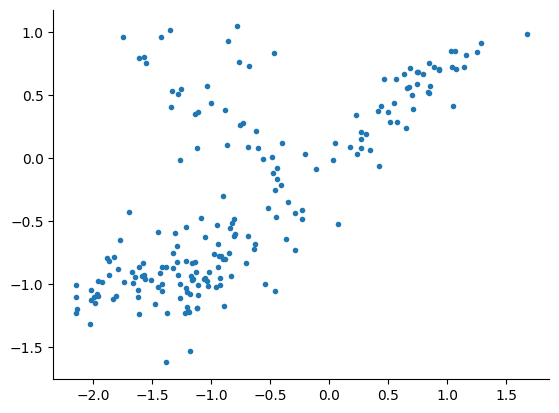

In [51]:
plt.plot(d['bert_coef_unigram1'] + d['bert_coef_unigram2'], d['bert_coef_bigram'], '.')